First we will import relevant packages that we need for our option pricing module

In [305]:
import pandas as pd
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as si
import matplotlib.pyplot as plt
from datetime import datetime


Now we will define the stock that we want to analyze along with the date that we want to analyze it for

In [306]:
ticker = 'AAPL'
start_date = '2022-01-01'
end_date = '2024-12-31'

Now we will define function that we will use to get our data from YahooFinance and process it 

In [307]:

def get_stock_data(ticker, start_date, end_date):
    ticker_data = pd.DataFrame()
    ticker = yf.Ticker(ticker)
    ticker_data = ticker.history(start = start_date, end = end_date)
    ticker_data = ticker_data['Close']
    return ticker_data


Now we get our logarithmic prices and volatilities

In [308]:
def get_log_prices(data):
    log_prices = np.log(data)-np.log(data).shift(1)
    log_prices = log_prices[1:]

    return log_prices

#rolling window vol
def calculate_volatilities(log_prices, window = 20):
    volatilities = log_prices.rolling(252).std()
    volatilities = volatilities[1:]

    return volatilities

#static vol
def calculate_volatility(log_prices):
    volatility=log_prices.std()

    return volatility


Lets create a function to plot the price, the returns and the volatilities over our given timeframe - but first we will run our functions. 

In [309]:
prices = get_stock_data(ticker, start_date,end_date)
log_prices = get_log_prices(prices)
volatilities = calculate_volatilities(log_prices)
volatility = calculate_volatility(log_prices)


In [310]:
def plot_prices(prices):
    plt.title(f"closing prices for {ticker}")
    plt.xlabel("time")
    plt.ylabel("prices")
    plt.plot(prices)
    plt.grid(True)
    plt.show()

def plot_logs(logs):
    plt.title(f"log returns for {ticker}")
    plt.xlabel("time")
    plt.ylabel("returns")
    plt.plot(logs)
    plt.grid(True)
    plt.show()

def plot_vols(vols):
    plt.title(f"volatilities for {ticker}")
    plt.xlabel("time")
    plt.ylabel("volatilities")
    plt.plot(vols)
    plt.grid(True)
    plt.show()

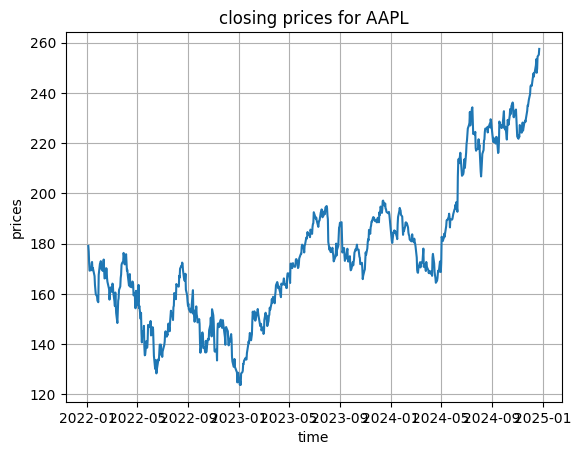

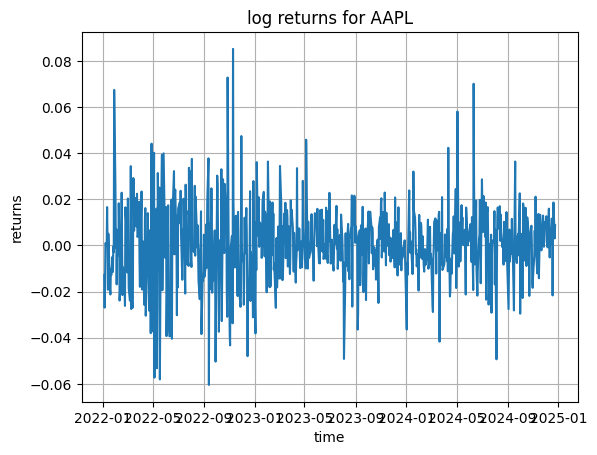

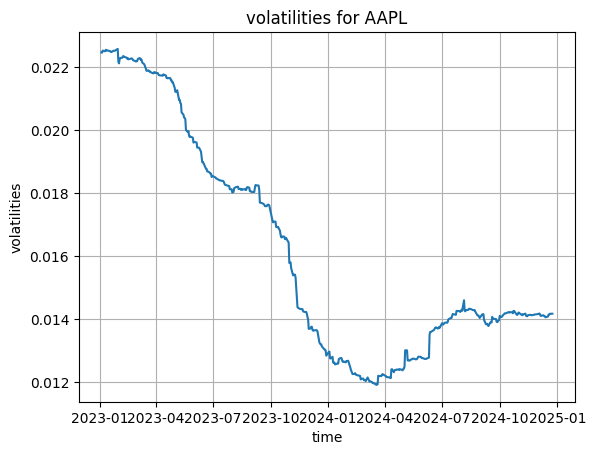

In [311]:
plotprice = plot_prices(prices)
plotlogs = plot_logs(log_prices)
plotvols = plot_vols(volatilities)

Now we will start building our Monte Carlo simulation engine using the price that we derived. We will begin by setting the parameters for our simulation. 

The parameters are: 
type of option: call or put option 
s0: the last price of the stock that we want to simulate for
r: the risk free rate
sigma: our volatility
T: The time to maturity
N: the numbers of time interval we will apply for our discretization 
n: The number of simulations 


In [312]:
S0 = prices[-1]
r = 0.045
sigma = calculate_volatility(log_prices) * np.sqrt(252)
T = 0.25
days = 252
Nsteps = int(days) #change this based on the granularity of the monte carlo simulation you want to achieve
Nrep = int(5000)

print(sigma)


0.2708831103641996


C:\Users\maxim\AppData\Local\Temp\ipykernel_11408\2885097260.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S0 = prices[-1]


In this Monte Carlo simulation, we model stock price movements using the Geometric Brownian Motion (GBM) framework, a widely used stochastic process in finance. GBM assumes that stock prices evolve continuously based on the stochastic differential equation: $dS_t$ = $rS_tdt$ + $sigma$ $S_t$ $dW_t$

where $S_t$ is the stock price at time $t$, $r$ is the risk free rate (currently 4.5% for a 10 year us treasury), sigma is the volatility and $dWt$ represents a wiener process (random walk)

In [313]:
class MonteCarloSimulation:
    def __init__(self,S0,T,Nsteps,Nrep,r,sigma):
        self.S0 = S0 
        self.T = T 
        self.Nsteps = Nsteps 
        self.Nrep = Nrep
        self.r = r
        self.sigma = sigma

    def mc_asset(self):
        simulated_paths = np.zeros((self.Nrep, 1 + self.Nsteps))
        simulated_paths[:, 0] = self.S0  
        dt = self.T/self.Nsteps
        nudt = (self.r - 0.5 * self.sigma**2) * dt
        sidt = self.sigma * np.sqrt(dt)
        for i in range(self.Nrep): 
            for j in range(self.Nsteps):  
                simulated_paths[i, j + 1] = simulated_paths[i, j] * np.exp(nudt + sidt * np.random.normal())

        return simulated_paths


In [314]:
mc = MonteCarloSimulation(S0,T,Nsteps,Nrep,r,sigma)
simulation = mc.mc_asset()

In [315]:

print(simulation)

[[257.54998779 250.44000698 249.50750382 ... 286.37896471 287.07830779
  288.22693828]
 [257.54998779 258.74120986 261.57048282 ... 264.59866501 266.38261843
  265.84262083]
 [257.54998779 254.50167113 254.09042561 ... 269.56678014 268.75417981
  273.47268313]
 ...
 [257.54998779 259.25894447 260.73879963 ... 284.08771707 284.28108493
  285.64482192]
 [257.54998779 258.92179927 263.37540517 ... 282.32206048 285.18819532
  288.25344261]
 [257.54998779 260.44986883 259.74621891 ... 291.23798454 291.5310132
  295.24383163]]


In [316]:

def plot_simulation(paths, ticker):

    plt.figure(figsize=(12, 6))
    plt.title(f"Monte Carlo Simulation for {ticker}", fontsize=16, fontweight="bold")
    plt.xlabel("Time Steps", fontsize=12)
    plt.ylabel("Price", fontsize=12)

    # Plot each selected path
    for path in paths:
        plt.plot(path, alpha=0.8)

    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


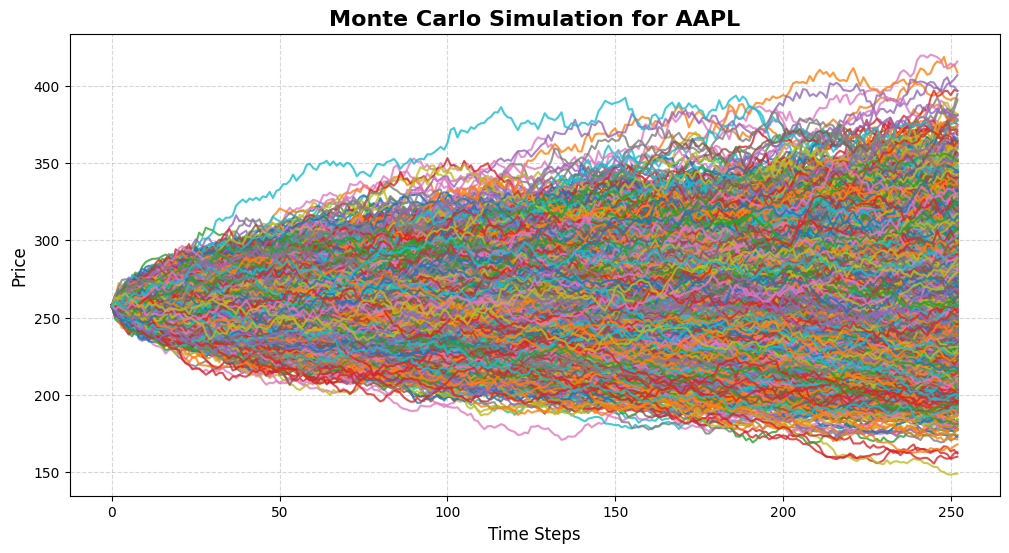

In [317]:
plot_simulation(simulation, ticker)

Now that we have arrived at our simulated price, I want to incorporate this price into our option pricing methods. First we need to extract the price from our simulation, the upper bound, the lower bound and the mean.

In [318]:
def extract_price(simulation):
    prices = simulation[-1,:]
    low_bound_prices = np.percentile(prices,0.5)
    up_bound_prices = np.percentile(prices,99.5)
    mean_price = np.mean(prices)

    print(f'The simulated price of {ticker} is {mean_price}')
    print(f'the lower bound for the stock {ticker} is {low_bound_prices}')
    print(f'the upper bounder for the stock {ticker} is {up_bound_prices}')

    return mean_price, low_bound_prices, up_bound_prices


mean_price, low_bound_price, up_bound_price = extract_price(simulation)




The simulated price of AAPL is 284.3299436626482
the lower bound for the stock AAPL is 256.79245132237367
the upper bounder for the stock AAPL is 302.34071034369106


Now we will build our Black scholes model


In [319]:
class BlackScholesModel:
    def __init__(self, S_t, K, t, r, sigma):
        self.S_t = S_t
        self.K = K
        self.t = t
        self.r = r
        self.sigma = sigma
    def d1(self):
        return (np.log(self.S_t / self.K) + (self.r + 0.5 * self.sigma**2) * self.t) / (self.sigma * np.sqrt(self.t))
    def d2(self):
        return self.d1() - self.sigma * np.sqrt(self.t)
    def call_price(self):
        return (self.S_t * si.norm.cdf(self.d1()) - self.K * np.exp(-self.r * self.t) * si.norm.cdf(self.d2()))
    def put_price(self):
        return (self.K * np.exp(-self.r * self.t) * si.norm.cdf(-self.d2()) - self.S_t * si.norm.cdf(-self.d1()))

In [320]:

price_prediction = float(input("By how much do you think the price will increase by? (Choose a value between -1.0 and 1.0 where 0 means that the price will not change, -1 means it will lose 100 percent of its value, and 1 means it will gain 100 percent of its value): "))

if price_prediction > 0:
    K = mean_price * (1 + price_prediction)
elif price_prediction < 0:
    K = mean_price * (1 + price_prediction)  
else:
    K = mean_price  


print(f"The calculated strike price (K) is: {K}")


t = 0.25 
S_t = mean_price



The calculated strike price (K) is: 312.762938028913


In [321]:
bsm = BlackScholesModel(S_t,K,t,r,sigma)
option_type = input('Please input your option type: Call or Put')
d1 = bsm.d1()
d2 = bsm.d2()

if option_type == 'Call':
    option_price = bsm.call_price()
elif option_type == 'Put':
    option_price = bsm.put_price()
else:
    raise KeyError('You need to select either Call or Put')

print(f"the {option_type} option price is {option_price}")

the Call option price is 6.5417775510412355


Now lets analyze some greeks
1. Delta
2. Gamma
3. Theta
4. Rho

In [322]:
class Greeks(BlackScholesModel):
    def delta_call(self):
        return si.norm.cdf(self.d1())
    def delta_put(self):
        return -si.norm.cdf(-self.d1())
    def gamma(self):
        return si.norm.pdf(self.d1()) / (self.S_t * self.sigma * np.sqrt(self.t))
    def vega(self):
        return self.S_t * si.norm.pdf(self.d1()) * np.sqrt(self.t)
    def theta_call(self):
        return (- (self.S_t * si.norm.pdf(self.d1()) * self.sigma) / (2 * np.sqrt(self.t))- self.r * self.K * np.exp(-self.r * self.t) * si.norm.cdf(self.d2()))
    def theta_put(self):
        return (- (self.S_t * si.norm.pdf(self.d1()) * self.sigma) / (2 * np.sqrt(self.t))+ self.r * self.K * np.exp(-self.r * self.t) * si.norm.cdf(-self.d2()) )
    def rho_call(self):
        return self.K * self.t * np.exp(-self.r * self.t) * si.norm.cdf(self.d2())
    def rho_put(self):
        return -self.K * self.t * np.exp(-self.r * self.t) * si.norm.cdf(-self.d2())

In [323]:
BlackScholesGreeks = Greeks(S_t, K, t, r, sigma)

print(f"Call Delta: {BlackScholesGreeks.delta_call()}")
print(f"Put Delta: {BlackScholesGreeks.delta_put()}")
print(f"Gamma: {BlackScholesGreeks.gamma()}")
print(f"Vega: {BlackScholesGreeks.vega()}")
print(f"Theta Put: {BlackScholesGreeks.theta_put()}")
print(f"Theta Call: {BlackScholesGreeks.theta_call()}")
print(f"Rho Call: {BlackScholesGreeks.rho_call()}")
print(f"Rho Put: {BlackScholesGreeks.rho_put()}")

Call Delta: 0.29016003706308185
Put Delta: -0.7098399629369181
Gamma: 0.008890983950686809
Vega: 48.676232905046355
Theta Put: -15.872428880347288
Theta Call: -29.789312165073863
Rho Call: 18.989852360064184
Rho Put: -58.326165888416796


Now we want to visualize how the Greeks change for different values of the Asset Price, Volatility, Time and Interest Rate

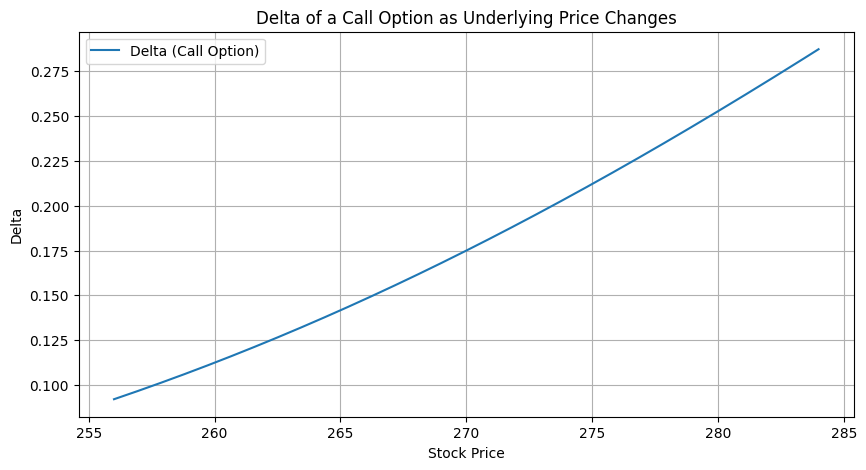

In [324]:
price_graph = np.linspace(int(low_bound_price),int(mean_price), int(up_bound_price)) 

deltas = [Greeks(price, K, t, r, sigma).delta_call() for price in price_graph]

plt.figure(figsize=(10, 5))
plt.plot(price_graph, deltas, label="Delta (Call Option)")
plt.title("Delta of a Call Option as Underlying Price Changes")
plt.xlabel("Stock Price")
plt.ylabel("Delta")
plt.grid(True)
plt.legend()
plt.show()